# import paths and libraries

In [74]:
from pathlib import Path
from dotenv import load_dotenv

try:
    start = Path(__file__).resolve()
except NameError:
    start = Path.cwd()

supporting_files = next(p / "00-supporting-files" for p in start.parents if (p / "00-supporting-files").exists())

In [3]:
project_parent = next(p for p in (start.resolve(), *start.resolve().parents) if (p / "00-supporting-files").exists()).parent
project_parent

PosixPath('/home/bedhedd/Documents/development_projects/bedhedd_projects/dougpt')

In [4]:
video_dir = project_parent / "large-files"
video_dir

PosixPath('/home/bedhedd/Documents/development_projects/bedhedd_projects/dougpt/large-files')

In [6]:
data_dir = supporting_files / "data"
data_dir

PosixPath('/home/bedhedd/Documents/development_projects/bedhedd_projects/dougpt/dougpt/00-supporting-files/data')

In [22]:
example_frame = supporting_files / "data" / "example.png"
example_frame

PosixPath('/home/bedhedd/Documents/development_projects/bedhedd_projects/dougpt/dougpt/00-supporting-files/data/example.png')

# openai client

In [77]:
import base64
from openai import OpenAI

def image_file_to_data_url(path: str) -> str:
    # Change mime if needed: image/jpeg, image/webp, etc.
    mime = "image/png"
    with open(path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("utf-8")
    return f"data:{mime};base64,{b64}"

client = OpenAI(
    base_url="http://localhost:1234/v0",  # or http://localhost:8000/v1
    api_key="unused",  # many local servers ignore this
)

client = OpenAI(
    base_url="http://localhost:1234/v1",
    api_key="lm-studio"
)

In [ ]:
import json
import requests
from typing import Optional, Tuple, Type
from pydantic import BaseModel


def extract_first_message_text(output_items: list[dict]) -> str:
    # /api/v1/chat can return multiple output items (message, reasoning, tool_call, etc.)
    # We only want the first "message" item for structured JSON content.
    for item in output_items:
        if item.get("type") == "message" and isinstance(item.get("content"), str):
            return item["content"]
    raise ValueError("No output item of type='message' found")


def extract_json_object(text: str) -> str:
    # If the model accidentally wraps JSON with extra text, this pulls the first {...} block.
    i = text.find("{")
    j = text.rfind("}")
    if i == -1 or j == -1 or j <= i:
        raise ValueError("No JSON object found in model output")
    return text[i : j + 1]


def lmstudio_v1_chat_parse(
    *,
    base_url: str,               # e.g. "http://localhost:1234"
    model: str,
    response_model: Type[BaseModel],
    input_text: str,             # your user message (or your existing prompt)
    system_prompt: str = "",
    api_token: Optional[str] = None,
    max_output_tokens: Optional[int] = None,
    temperature: Optional[float] = None,
    previous_response_id: Optional[str] = None,
    store: bool = False,
) -> Tuple[BaseModel, dict, dict]:
    """
    Returns: (validated_pydantic_obj, stats_dict, raw_response_dict)
    """

    schema = response_model.model_json_schema()

    # Force JSON-only output via system_prompt.
    # /api/v1/chat does not document OpenAI-style response_format; it documents system_prompt + input. :contentReference[oaicite:1]{index=1}
    full_system = (
        (system_prompt.strip() + "\n\n") if system_prompt.strip() else ""
    ) + (
        "Return ONLY a valid JSON object that matches this JSON Schema.\n"
        "Do not wrap in markdown. Do not add extra keys.\n"
        f"JSON Schema: {json.dumps(schema, ensure_ascii=False)}"
    )

    payload: dict = {
        "model": model,
        "input": input_text,
        "system_prompt": full_system,
        "store": store,
    }
    if previous_response_id:
        payload["previous_response_id"] = previous_response_id
    if max_output_tokens is not None:
        payload["max_output_tokens"] = max_output_tokens
    if temperature is not None:
        payload["temperature"] = temperature

    headers = {"Content-Type": "application/json"}
    if api_token:
        headers["Authorization"] = f"Bearer {api_token}"

    r = requests.post(f"{base_url}/api/v1/chat", headers=headers, json=payload, timeout=300)
    r.raise_for_status()

    raw = r.json()

    # 1) Extract text from output items
    msg_text = extract_first_message_text(raw["output"])

    # 2) Validate as pydantic
    # Prefer direct JSON parse; fallback to extracting {...} if the model adds extra text.
    try:
        validated = response_model.model_validate_json(msg_text)
    except Exception:
        validated = response_model.model_validate_json(extract_json_object(msg_text))

    # 3) Stats are top-level in /api/v1/chat response. :contentReference[oaicite:2]{index=2}
    stats = raw.get("stats", {})

    return validated, stats, raw


# ---- usage (mirrors your OpenAI SDK parse pattern) ----
# validated, stats, raw = lmstudio_v1_chat_parse(
#     base_url="http://localhost:1234",
#     model=MODEL,
#     response_model=ChatExtraction,
#     input_text="...your prompt here...",
#     temperature=0,
#     max_output_tokens=4096,
#     store=False,
# )
#
# print(validated.model_dump_json(indent=2))
# print(json.dumps(stats, indent=2))


In [9]:
# from __future__ import annotations

from pathlib import Path
from typing import Iterable, Union, Dict, Any, List, Tuple, Optional
# from typing import Dict, Any, Tuple
from PIL import Image, ImageDraw, ImageFont
# from PIL import ImageDraw, ImageFont


def _safe_clamped_bbox(
    x: int, y: int, w: int, h: int, *,
    W: int, H: int,
    pad: int = 0,
) -> Optional[Tuple[int, int, int, int]]:
    """
    Returns (left, top, right, bottom) in image pixel space, or None if bbox
    is completely outside / invalid after clamping.
    """
    if w <= 0 or h <= 0:
        return None

    left   = x - pad
    top    = y - pad
    right  = x + w + pad
    bottom = y + h + pad

    # If entirely outside, skip
    if right <= 0 or bottom <= 0 or left >= W or top >= H:
        return None

    # Clamp to image bounds
    left   = max(0, min(left, W))
    top    = max(0, min(top, H))
    right  = max(0, min(right, W))
    bottom = max(0, min(bottom, H))

    # If empty after clamp, skip
    if right <= left or bottom <= top:
        return None

    return (left, top, right, bottom)


def draw_emote_bboxes_safe(
    image_path: Union[str, Path],
    emotes: Iterable[Union[Dict[str, Any], Any]],  # dict or Pydantic EmoteBox
    out_path: Union[str, Path, None] = None,
    *,
    pad: int = 0,
    stroke: int = 3,
) -> Path:
    image_path = Path(image_path)
    if out_path is None:
        out_path = image_path.with_name(f"{image_path.stem}__bboxes.png")
    out_path = Path(out_path)

    im = Image.open(image_path).convert("RGBA")
    W, H = im.size
    draw = ImageDraw.Draw(im)

    for e in emotes:
        # support dict or pydantic model
        if hasattr(e, "model_dump"):
            e = e.model_dump()

        bbox = _safe_clamped_bbox(
            int(e["x"]), int(e["y"]), int(e["w"]), int(e["h"]),
            W=W, H=H, pad=pad,
        )
        if bbox is None:
            continue

        draw.rectangle(bbox, outline=(255, 0, 0, 255), width=stroke)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    im.save(out_path)
    return out_path


# Example usage:
# emotes = [
#     {"x": 176, "y": 48, "w": 52, "h": 52, "description": "peeposad"},
#     {"x": 385, "y": 821, "w": 51, "h": 52, "description": "mariomusic"},
# ]
# out_files = crop_emotes("/path/to/image.png", emotes, pad=2)
# print(out_files)


In [11]:
from pydantic import BaseModel, Field

class EmoteBox(BaseModel):
    emote_name: str = Field(..., description="a shorthand name for the emote (e.g., 'PepeHands', 'POG', 'OMEGALUL', 'D:'   'CINEMA', 'dougdougPump').")
    description: str = Field(..., description="Short human-readable description of the emote use a full description rather than a the emoji shorthand")

class ChatMessage(BaseModel):
    user_name: str = Field(..., description="Username as shown in the chat UI for this line (no inferred/extra metadata).")
    message: str = Field(..., description="Visible message text and emoji (described as 1 word) for this chat line. If emotes and emojis are in the message, include them inline and use a structure of `:emote_described:` `:another_emote_described:` ...")
    emotes: List[EmoteBox] = Field(..., description="list of unique emotes, can be empty ignore images next to the name just focus on emotes/emojis after the name")

class ChatExtraction(BaseModel):
    chat_messages: List[ChatMessage] = Field(
        default_factory=list,
        description="All visible chat lines in a single image, in top-to-bottom reading order.",
    )

In [37]:
labeled_example = """
The extracted output from the reference is 
{{
  "user_name": "ToaSTy_T0aST",
  "message": "nvm its on a cooldown :pepehands:",
  "emotes": [
    {
      "emote_name": "peepehands",
      "description": "pepe the frong crying"
    }
  ]
},
{
  "user_name": "frickelodeon",
  "message": "@iamkaalhode believe in the doubt",
  "emotes": []
},
  {
  "user_name": "sour_appel",
  "message": "So when Doug won't open the oxygen gates, we have to rely on the fart barons",
  "emotes": []
}}
""".strip()  

print(labeled_example)

The extracted output from the reference is 
{{
  "user_name": "ToaSTy_T0aST",
  "message": "nvm its on a cooldown :pepehands:",
  "emotes": [
    {
      "emote_name": "peepehands",
      "description": "pepe the frong crying"
    }
  ]
},
{
  "user_name": "frickelodeon",
  "message": "@iamkaalhode believe in the doubt",
  "emotes": []
},
  {
  "user_name": "sour_appel",
  "message": "So when Doug won't open the oxygen gates, we have to rely on the fart barons",
  "emotes": []
}}


[{'type': 'text',
  'text': "You are a helpful assistant who is extracting twitch usernames and messages# MESSAGE TEXT EXTRACTION INSTRUCTIONS\n- Keep the visible message text.\n- Replace each INLINE message emote with a one word description, include them inline and use a structure of `:emote_described:` `:another_emote_described:` ... in the message.\n- Do not insert :oneword: tokens for left-gutter UI icons.\n\n- Order emotes left-to-right.\n\nIf message text is not visible, use '(No message text visible)'.\n"},
 {'type': 'text', 'text': '# EXAMPLE IMAGE \n \nfor example this image:'},
 {'type': 'image_url',
  'image_url': {'url': ''}},
 {'type': 'text',
  'text': 'The extracted output from the reference is \n{{\n  "user_name": "ToaSTy_T0aST",\n  "message": "nvm its on a cooldown :pepehands:",\n  "emotes": [\n    {\n      "emote_name": "peepehands",\n      "description": "pepe the frong crying"\n    }\n  ]\n},\n{\n  "user_name": "frickelodeon",\n  "message": "@iamkaalhode believe in 
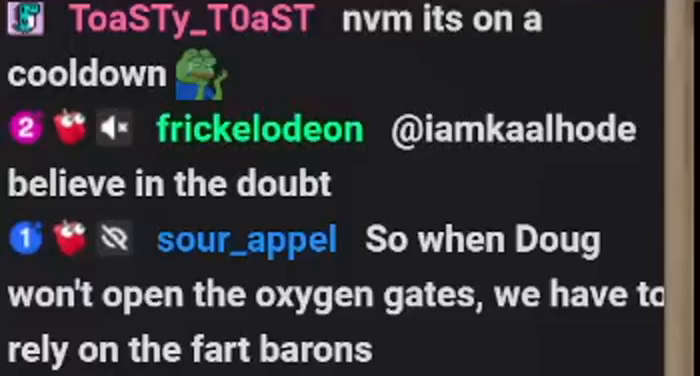

In [38]:
# ---------- pick first 8 files ----------
FRAMES_DIR = video_dir / "Doug_and_Twitch_Chat_TAKE_OVER_EUROPE-VpmmuHlLPM0__crop_no_audio__crop_0x14_350x460__s2" / "chat_frames"

exts = {".jpg", ".jpeg", ".png", ".webp"}
files = sorted([p for p in FRAMES_DIR.iterdir() if p.is_file() and p.suffix.lower() in exts])
# if len(files) < 8:
#     raise RuntimeError(f"Need at least 8 images in {FRAMES_DIR.resolve()}, found {len(files)}")

instructions = [{
    "type": "text",
    "text": (
        "You are a helpful assistant who is extracting twitch usernames and messages"
        "# MESSAGE TEXT EXTRACTION INSTRUCTIONS\n"
        "- Keep the visible message text.\n"
        "- Replace each INLINE message emote with a one word description, include them inline and use a structure of `:emote_described:` `:another_emote_described:` ... in the message.\n"
        "- Do not insert :oneword: tokens for left-gutter UI icons.\n"
        "\n"
        "- Order emotes left-to-right.\n"
        "\n"
        "If message text is not visible, use '(No message text visible)'.\n"),
        }, 
           {"type": "text", "text": f"# EXAMPLE IMAGE \n \nfor example this image:"},
           {"type": "image_url", "image_url": {"url": image_file_to_data_url(example_frame)}},
           {"type": "text", "text": labeled_example},
           {"type": "text", "text": f"the emojis in front of the username are decorators, so avoid adding the icons before the username as emojis:"},
          ]

instructions          

In [ ]:
def create_instructions(file_path, instructions=None, previous_extraction=None):
    """
    file_path: a string to a single image file that needs to be embedded for the model
    instructions: the instructions that prepend to the image in the structure {"type": "text", "text": "text goes here"}. If None, a default will be set
    previous_extraction: the previous extraction results
    """
    # w, h = Image.open(file_path).size
    # image_unique_id = file_path.stem
    if instructions is None:
        instructions = [{
    "type": "text",
    "text": (
        "You are a helpful assistant who is extracting twitch usernames and messages"
        "# MESSAGE TEXT EXTRACTION INSTRUCTIONS\n"
        "- Keep the visible message text.\n"
        "- Replace each INLINE message emote with a one word description, include them inline and use a structure of `:emote_described:` `:another_emote_described:` ... in the message.\n"
        "- Do not insert :oneword: tokens for left-gutter UI icons.\n"
        "\n"
        "- Order emotes left-to-right.\n"
        "\n"
        "If message text is not visible, use '(No message text visible)'.\n"),
        }, 
           {"type": "text", "text": f"# EXAMPLE IMAGE \n \nfor example this image:"},
           {"type": "image_url", "image_url": {"url": image_file_to_data_url(example_frame)}},
           {"type": "text", "text": labeled_example},
           {"type": "text", "text": f"Notice that the emojis in front of the username are decorators, so avoid adding the icons before the username as emojis:"},
          ]

    if previous_extraction is not None:
        previous_messages = "The previous messages include:\n".join(
            f"{m.user_name}:{m.message.strip() or '...'}"
            for m in previous_extraction.chat_messages[-3:]
            )
        instructions.append({"type": "text", "text": previous_messages})

    instructions.append({"type": "text", "text": "Repeat the process above for the following image:"})
    instructions.append({"type": "image_url", "image_url": {"url": image_file_to_data_url(file_path)}})
    return instructions


In [41]:
files[4]

PosixPath('/home/bedhedd/Documents/development_projects/bedhedd_projects/dougpt/large-files/Doug_and_Twitch_Chat_TAKE_OVER_EUROPE-VpmmuHlLPM0__crop_no_audio__crop_0x14_350x460__s2/chat_frames/frame_000053_t000017.667.png')

[{'type': 'text',
  'text': "You are a helpful assistant who is extracting twitch usernames and messages# MESSAGE TEXT EXTRACTION INSTRUCTIONS\n- Keep the visible message text.\n- Replace each INLINE message emote with a one word description, include them inline and use a structure of `:emote_described:` `:another_emote_described:` ... in the message.\n- Do not insert :oneword: tokens for left-gutter UI icons.\n\n- Order emotes left-to-right.\n\nIf message text is not visible, use '(No message text visible)'.\n"},
 {'type': 'text', 'text': '# EXAMPLE IMAGE \n \nfor example this image:'},
 {'type': 'image_url',
  'image_url': {'url': ''}},
 {'type': 'text',
  'text': 'The extracted output from the reference is \n{{\n  "user_name": "ToaSTy_T0aST",\n  "message": "nvm its on a cooldown :pepehands:",\n  "emotes": [\n    {\n      "emote_name": "peepehands",\n      "description": "pepe the frong crying"\n    }\n  ]\n},\n{\n  "user_name": "frickelodeon",\n  "message": "@iamkaalhode believe in 
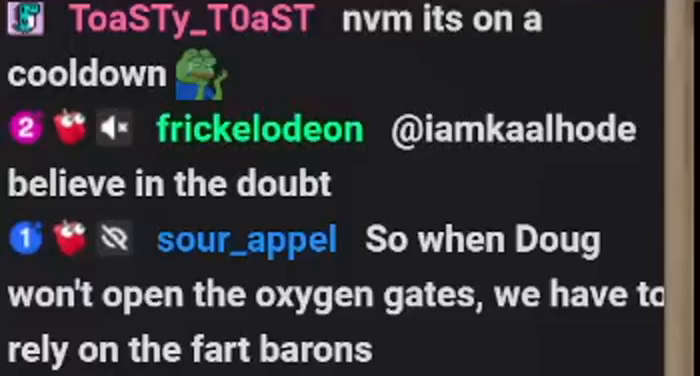
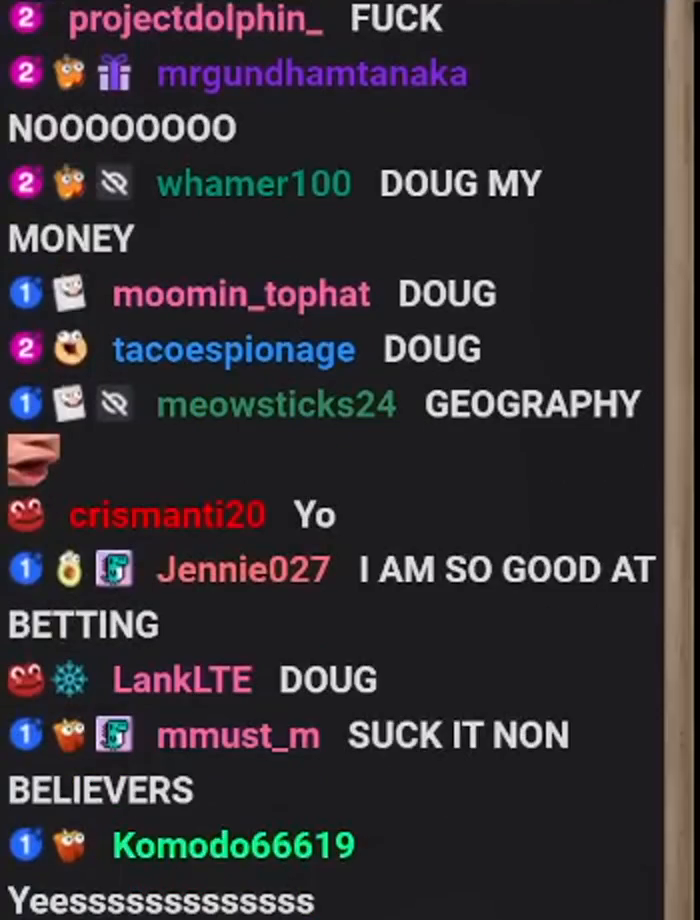

In [48]:
intructions_for_llm = create_instructions(files[4])
intructions_for_llm

[{'role': 'user', 'content': [{'type': 'text', 'text': "You are a helpful assistant who is extracting twitch usernames and messages# MESSAGE TEXT EXTRACTION INSTRUCTIONS\n- Keep the visible message text.\n- Replace each INLINE message emote with a one word description, include them inline and use a structure of `:emote_described:` `:another_emote_described:` ... in the message.\n- Do not insert :oneword: tokens for left-gutter UI icons.\n\n- Order emotes left-to-right.\n\nIf message text is not visible, use '(No message text visible)'.\n"}, {'type': 'text', 'text': '# EXAMPLE IMAGE \n \nfor example this image:'}, {'type': 'image_url', 'image_url': {'url': ''}}, {'type': 'text', 'text': 'The extracted output from the reference is \n{{\n  "user_name": "ToaSTy_T0aST",\n  "message": "nvm its on a cooldown :pepehands:",\n  "emotes": [\n    {\n      "emote_name": "peepehands",\n      "description": "pepe the frong crying"\n    }\n  ]\n},\n{\n  "user_name": "frickelodeon",\n  "message": "@iam
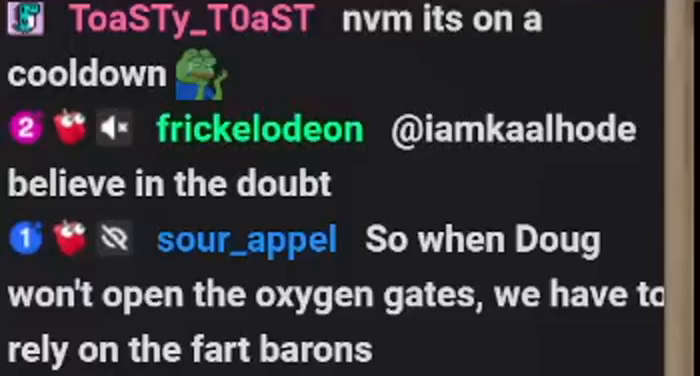
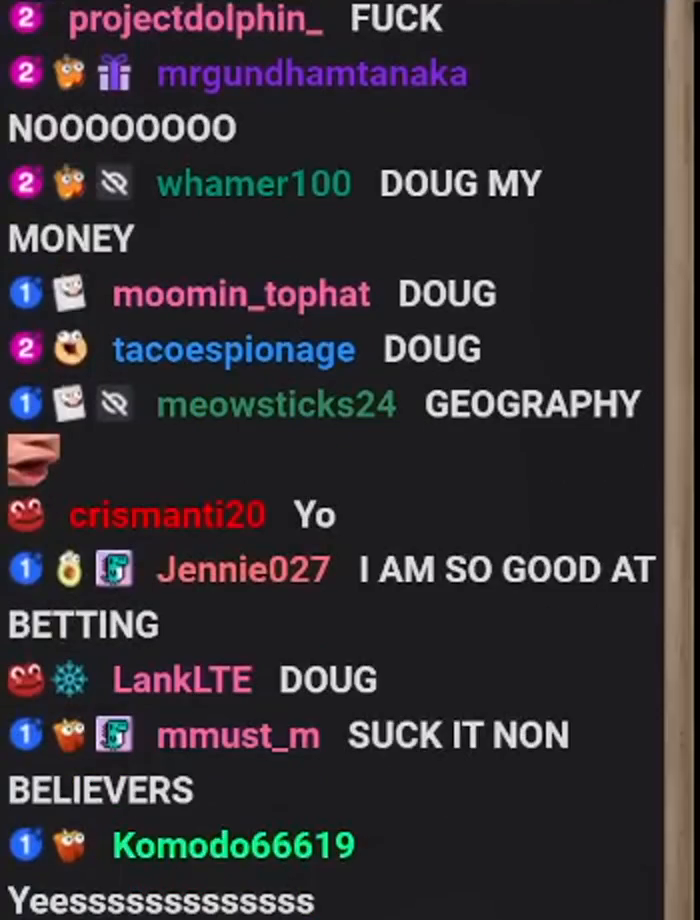

In [49]:
messages = [{"role": "user", "content": intructions_for_llm}]
print(messages)

In [ ]:
MODEL = "lmstudio-community/Qwen3-VL-30B-A3B-Instruct-GGUF"
MODEL = "qwen3-vl-30b-a3b-thinking"

# Preferred: structured parse (if your server supports it)
single_resp = client.beta.chat.completions.parse(
    model=MODEL,
    response_format=ChatExtraction,
    messages=messages,
    # temperature=0.2,
    max_tokens=-1,
)

single_resp_parsed = single_resp.choices[0].message.parsed
single_resp_validated = ChatExtraction.model_validate(single_resp_parsed)

print(single_resp_validated.model_dump_json(indent=2))

{
  "chat_messages": [
    {
      "user_name": "projectdolphin_",
      "message": "FUCK NOOOOOOOO",
      "emotes": []
    },
    {
      "user_name": "mrgundhamtanaka",
      "message": "DOUG MY MONEY",
      "emotes": []
    },
    {
      "user_name": "whamer100",
      "message": "DOUG MY MONEY",
      "emotes": []
    },
    {
      "user_name": "moomin_tophat",
      "message": "DOUG",
      "emotes": []
    },
    {
      "user_name": "tacoespionage",
      "message": "DOUG",
      "emotes": []
    },
    {
      "user_name": "meowsticks24",
      "message": "GEOGRAPHY",
      "emotes": []
    },
    {
      "user_name": "crismanti20",
      "message": "Yo",
      "emotes": [
        {
          "emote_name": "redface",
          "description": "red face emoji"
        }
      ]
    },
    {
      "user_name": "Jennie027",
      "message": "I AM SO GOOD AT BETTING",
      "emotes": []
    },
    {
      "user_name": "LankLTE",
      "message": "DOUG",
      "emotes": [
       

In [ ]:
validated, stats, raw = lmstudio_v1_chat_parse(
    base_url="http://localhost:1234",
    model=MODEL,
    response_model=ChatExtraction,
    input_text="...your prompt here...",
    temperature=0,
    # max_output_tokens=4096,
    store=False,
)

print(validated.model_dump_json(indent=2))
print(json.dumps(stats, indent=2))

In [58]:
single_resp_validated.chat_messages[-3:]

[ChatMessage(user_name='LankLTE', message='DOUG', emotes=[EmoteBox(emote_name='snowflake', description='snowflake emoji')]),
 ChatMessage(user_name='mmust_m', message='SUCK IT NON', emotes=[]),
 ChatMessage(user_name='Komodo66619', message='', emotes=[])]

In [99]:
import json
from pathlib import Path
from typing import Any, Optional

def append_jsonl(path: Path, obj: Any, *, indent: Optional[int] = None) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)

    if hasattr(obj, "model_dump"):
        obj = obj.model_dump()

    text = json.dumps(obj, ensure_ascii=False, indent=indent)
    with path.open("a", encoding="utf-8") as f:
        f.write(text)
        f.write("\n")  # separator between entries

# running it on the entire dataset

In [ ]:
from tqdm.auto import tqdm

import os, time
previous_extraction = None
extracted_images = []
metrics = []

EXTRACTIONS_OUT = data_dir / "extractions" / "extractions.jsonl"
METRICS_OUT = data_dir / "extractions" / "metrics.jsonl"
frames = list(FRAMES_DIR.iterdir())

In [125]:
from functools import wraps
from pydantic import ValidationError
def retry_until_valid(func):
    @wraps(func)                       # keep metadata
    def wrapper(*args, **kwargs):      # forward any signature
        attempt = 1
        while True:
            try:
                return func(*args, **kwargs)
            except ValidationError as e:
                print(f"Attempt #{attempt} failed: {e}")
                attempt += 1           # loop back → new LLM call
    return wrapper 

In [149]:
from __future__ import annotations

from functools import wraps
from pydantic import ValidationError

# robust import across openai sdk versions
try:
    from openai import LengthFinishReasonError
except Exception:
    try:
        from openai.lib._parsing._completions import LengthFinishReasonError
    except Exception:
        LengthFinishReasonError = None


def retry_until_valid(
    max_attempts: int | None = None,
    bump_on_length: bool = True,
    bump_add: int = 256,
    bump_mul: float = 1.5,
):
    """
    Retries on:
      - pydantic.ValidationError (schema/validation)
      - LengthFinishReasonError (truncated due to max_tokens)

    If bump_on_length=True and kwargs contain soft_completion_tokens/hard_completion_cap,
    it will increase soft_completion_tokens on each length failure (up to hard_completion_cap).
    """
    retry_exc = (ValidationError,) + ((LengthFinishReasonError,) if LengthFinishReasonError else ())

    def deco(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            attempt = 1
            while True:
                try:
                    return func(*args, **kwargs)
                except retry_exc as e:
                    # length/truncation: bump tokens so the next attempt has room
                    if LengthFinishReasonError and isinstance(e, LengthFinishReasonError) and bump_on_length:
                        if "soft_completion_tokens" in kwargs:
                            prev = int(kwargs["soft_completion_tokens"])
                            hard = int(kwargs.get("hard_completion_cap", prev))
                            bumped = min(hard, max(prev + bump_add, int(prev * bump_mul)))

                            if bumped == prev:
                                # already at cap; retrying unchanged will likely loop forever
                                raise

                            kwargs["soft_completion_tokens"] = bumped
                            print(
                                f"Attempt #{attempt} hit finish_reason=length; "
                                f"bumping soft_completion_tokens {prev} -> {bumped}"
                            )
                        else:
                            print(f"Attempt #{attempt} hit finish_reason=length; retrying unchanged")
                    else:
                        print(f"Attempt #{attempt} failed: {e}")

                    attempt += 1
                    if max_attempts is not None and attempt > max_attempts:
                        raise

        return wrapper
    return deco


@retry_until_valid(max_attempts=None)
def extract_messages(
    *,
    MODEL,
    ChatExtraction,
    messages,
    soft_completion_tokens: int = 900,
    hard_completion_cap: int = 1600,
    ctx_margin: int = 128,
):
    # your existing max_tokens logic (example)
    prompt_est = 0  # replace with your real estimate if you have one
    cur_ctx = 4096  # replace with model ctx if you track it
    available = max(1, cur_ctx - prompt_est - ctx_margin)

    max_tokens = max(1, min(available, soft_completion_tokens, hard_completion_cap))

    extraction = client.beta.chat.completions.parse(
        model=MODEL,
        response_format=ChatExtraction,
        messages=messages,
        max_tokens=max_tokens,
    )

    parsed = extraction.choices[0].message.parsed
    validated_extraction = ChatExtraction.model_validate(parsed)  # may raise ValidationError

    return extraction, validated_extraction


In [142]:
previous_extraction

ChatExtraction(chat_messages=[ChatMessage(user_name='jorjo_frog', message='5', emotes=[]), ChatMessage(user_name='DaniDuck', message='5', emotes=[]), ChatMessage(user_name='charlizard59', message='1', emotes=[]), ChatMessage(user_name='sportspro02', message='1', emotes=[]), ChatMessage(user_name='dark82000000', message='5', emotes=[]), ChatMessage(user_name='hdude06', message='2', emotes=[]), ChatMessage(user_name='derpmerp1010', message='LETS JUST DO BOTH', emotes=[]), ChatMessage(user_name='somebodyesomeone', message='pick 5', emotes=[]), ChatMessage(user_name='MetaMeistR', message='5', emotes=[]), ChatMessage(user_name='skydemon52', message='SEDUCE :smiling_face_with_halo:', emotes=[EmoteBox(emote_name='smiling_face_with_halo', description='smiling face with halo')]), ChatMessage(user_name='MousiX', message='@DougDougW color in the countries that are active in the story - they are "barbarians" so make italy, switzerland and luxembourg red', emotes=[]), ChatMessage(user_name='ts251',

In [143]:
len(frames)

6543

In [127]:
from pathlib import Path

target_name = "frame_005213_t001737.667.png"

frame_paths = sorted(FRAMES_DIR.glob("frame_*.png"))  # deterministic order
try:
    target_idx0 = next(idx for idx, p in enumerate(frame_paths) if p.name == target_name)  # 0-based
except StopIteration:
    raise FileNotFoundError(f"Not found in {FRAMES_DIR}: {target_name}")

target_idx1 = target_idx0 + 1
total_frames = len(frame_paths)

print(f"position: {target_idx1}/{total_frames}  ({target_idx1/total_frames:.2%})")
print("path:", frame_paths[target_idx0])


position: 643/6543  (9.83%)
path: /home/bedhedd/Documents/development_projects/bedhedd_projects/dougpt/large-files/Doug_and_Twitch_Chat_TAKE_OVER_EUROPE-VpmmuHlLPM0__crop_no_audio__crop_0x14_350x460__s2/chat_frames/frame_005213_t001737.667.png


In [144]:
# MODEL = "lmstudio-community/Qwen3-VL-30B-A3B-Instruct-GGUF"
MODEL = "qwen3-vl-30b-a3b-thinking"

In [147]:
i

1632

In [150]:
i

1632

In [ ]:

# -------------------------
# Your loop (no try/except here)
# -------------------------

start_pos = 2511
previous_extraction = None  # or load from your output file if you have that logic

for i, image in enumerate(
    tqdm(frames[start_pos - 1 :], desc="Extracting", unit="frame"),
    start=start_pos,
):
    print("index:", i, f"extracting: {image.name}")

    intructions_for_llm = create_instructions(
        file_path=image,
        previous_extraction=previous_extraction,
    )
    messages = [{"role": "user", "content": intructions_for_llm}]

    t0 = time.perf_counter()
    extraction, validated_extraction = extract_messages(
        MODEL=MODEL,
        ChatExtraction=ChatExtraction,
        messages=messages,
    )
    elapsed_s = time.perf_counter() - t0

    resp_dict = extraction.model_dump() if hasattr(extraction, "model_dump") else dict(extraction)
    usage = resp_dict.get("usage") or {}

    metric_row = {
        "i": i,
        "filename": image.name,
        "elapsed_s": elapsed_s,
        **{f"usage_{k}": v for k, v in usage.items()},
    }
    metrics.append(metric_row)
    append_jsonl(METRICS_OUT, metric_row, indent=2)

    row = {
        "filename": image.name,
        "chat_messages": validated_extraction.model_dump(exclude_none=True)["chat_messages"],
    }
    append_jsonl(EXTRACTIONS_OUT, row, indent=2)

    extracted_images.append(row)
    previous_extraction = validated_extraction


Extracting:   0%|          | 0/4034 [00:00<?, ?frame/s]

index: 2510 extracting: frame_018806_t006268.667.png


Extracting:   0%|          | 1/4034 [00:09<10:14:55,  9.15s/frame]

index: 2511 extracting: frame_018816_t006272.000.png
Attempt #1 hit finish_reason=length; retrying unchanged
Attempt #2 hit finish_reason=length; retrying unchanged


Extracting:   0%|          | 1/4034 [00:57<64:33:04, 57.62s/frame]


KeyboardInterrupt: 

In [ ]:
1144